In [26]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt

In [2]:
import pandas as pd
import os

def load_df(asset_name: str, base_dir: str = None):
    if base_dir is None:
        # Get the current working directory and locate the 'crypto_qts_data_processed' folder
        base_dir = os.path.join(os.getcwd(), 'crypto_qts_data_processed')

    file_path = os.path.join(base_dir, f"{asset_name}_price_processed.parquet")

    if os.path.exists(file_path):
        return pd.read_parquet(file_path)
    else:
        raise FileNotFoundError(f"File not found: {file_path}")


In [32]:
def segmentation_rule(crypto: str,
                      jump = 5,
                      pen = 30, plot = False, dates= False):
    df = load_df(crypto)
    df = df[['price_close']]
    daily = df.loc[::24]

    c = rpt.Pelt(model = "rbf", min_size=3, jump=jump).fit(daily.values)
    model = c.predict(pen=pen)

    if plot:
        fig, ax = plt.subplots()
        ax.plot(daily.values, color = 'b')
        for r in model:
            ax.axvline(x = r, color = 'r', linestyle = '--')



    if dates:

        y = daily.reset_index()
        dates = []
        for m in model:
            m = m-1
            dates.append(y.loc[m,'index'])
    return dates


[Timestamp('2021-01-07 05:00:00+0000', tz='UTC'),
 Timestamp('2021-08-05 05:00:00+0000', tz='UTC'),
 Timestamp('2022-01-07 05:00:00+0000', tz='UTC'),
 Timestamp('2022-05-12 05:00:00+0000', tz='UTC'),
 Timestamp('2024-01-07 05:00:00+0000', tz='UTC'),
 Timestamp('2025-02-25 05:00:00+0000', tz='UTC')]

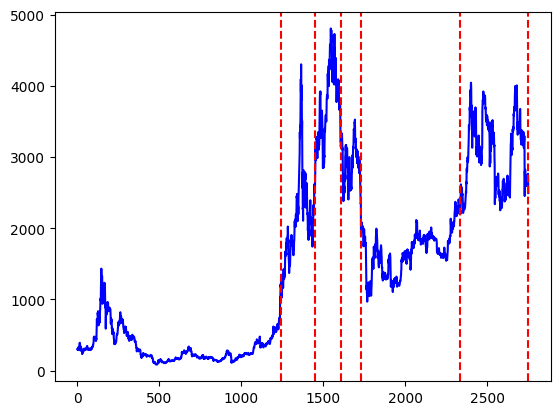

In [45]:
#See the plot, if you return dates, it'll show you the dates segmented
segmentation_rule(crypto= 'ETH',
                      jump = 5,
                      pen = 30, plot = True, dates= True)

In [24]:
def sparse_crypto(crypto = 'crypto',
                      jump = 5,
                      pen = 30,
                    plot = False,
                    dates = True):

    dates = segmentation_rule(crypto = crypto,
                      jump = jump,
                      pen = pen, plot = False, dates = True)

    dfs = {}
    for j in range(len(dates)-1):
        start = dates[j]
        end = dates[j+1]
        df = load_df(crypto).copy()
        df.reset_index(inplace = True)
        df_filtered = df[(df['index']>= start) & (df['index']< end)]
        df_filtered['start_date'] = start
        df_filtered['end_date'] = end

        dfs[f"df_{j}"] = df_filtered

    return dfs


In [39]:
#Each segmented df is stored in a dictionary

# eth_dfs = sparse_crypto(crypto = 'ETH',
#                       jump = 5,
#                       pen = 30,
#                     plot = False,
#                     dates = True)

In [33]:
def summary_table(crypto = 'BTC',
                      jump = 5,
                      pen = 30,
                    plot = False,
                    dates = True):
    dfs = sparse_crypto(crypto = crypto,
                      jump = jump,
                      pen = pen ,
                    plot = False,
                    dates = True)

    dfs_summary = {}

    for k, v in dfs.items():
        mean = v['price_close'].mean()
        stdv = v['price_close'].std()
        start_date = (v['start_date'].values[1])
        end_date = (v['end_date'].values[1])


        dfs_summary[k] = {'mean':mean, 'stdv':stdv, 'start_date':start_date, 'end_date':end_date}

    dfs_summary_df = pd.DataFrame.from_dict(dfs_summary, orient='index')

    return dfs_summary_df





In [34]:
#Summary of each df
# summary_table(crypto = 'ETH',
#                       jump = 5,
#                       pen = 30,
#                     plot = False,
#                     dates = True)

,mean,stdv,start_date,end_date
df_0,2114.953103,627.146114,2021-01-07 05:00:00,2021-08-05 05:00:00
df_1,3768.326766,518.457228,2021-08-05 05:00:00,2022-01-07 05:00:00
df_2,2911.608473,292.167232,2022-01-07 05:00:00,2022-05-12 05:00:00
df_3,1666.292052,298.424393,2022-05-12 05:00:00,2024-01-07 05:00:00
df_4,3059.139635,484.799471,2024-01-07 05:00:00,2025-02-25 05:00:00
